In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud

In [3]:
# Cargar el archivo de la merge previa
merged_df = pd.read_csv("merged_properties_bookings.csv")
merged_df.head()

,PropertyId,Property_BookingId,BookingCreatedDate,ArrivalDate,DepartureDate,Adults,Children,Infants,Persons,NumNights,...,Revenue,ADR,TouristTax,TotalPaid,RealProperty,Capacity,Square,PropertyType,NumBedrooms,ReadyDate
0,43469,155168,2024-10-03 16:42:13,2024-10-09 00:00:00,2024-10-12 00:00:00,2,0,0,2,3,...,391.03,130.34,3.96,394.99,Yes,2.0,31.0,Apartment,0.0,2024-02-23
1,43025,155167,NaN,2025-02-02 00:00:00,2025-02-07 00:00:00,3,0,0,3,5,...,1793.13,358.63,15.00,1808.13,Yes,4.0,60.0,Apa,2.0,2019-05-04
2,43404,155166,NaN,2024-11-18 00:00:00,2024-11-25 00:00:00,3,0,0,3,7,...,827.17,118.17,144.38,971.55,Yes,5.0,45.0,Unknown,2.0,2023-03-22
3,43276,155165,2024-10-03 15:55:39,2024-11-14 00:00:00,2024-11-18 00:00:00,5,0,0,5,4,...,692.86,173.22,137.50,830.36,Yes,5.0,64.0,Apartment,4.0,2022-02-15
4,4138,155164,2024-10-03 15:53:02,2024-11-20 00:00:00,2024-12-06 00:00:00,5,0,0,5,16,...,2005.43,125.34,240.63,2246.06,Yes,5.0,60.0,Apartment,2.0,2013-08-07


In [4]:
# Verificar el tamaño de la columnas y las cantidad de filas post merged
merged_df.shape

(87037, 23)

In [5]:
# Corrovorar que los cambios de variables realizados en el archivo previo 
merged_df.dtypes

PropertyId              int64
Property_BookingId      int64
BookingCreatedDate     object
ArrivalDate            object
DepartureDate          object
Adults                  int64
Children                int64
Infants                 int64
Persons                 int64
NumNights               int64
Channel                object
RoomRate              float64
CleaningFee           float64
Revenue               float64
ADR                   float64
TouristTax            float64
TotalPaid             float64
RealProperty           object
Capacity              float64
Square                float64
PropertyType           object
NumBedrooms           float64
ReadyDate              object
dtype: object

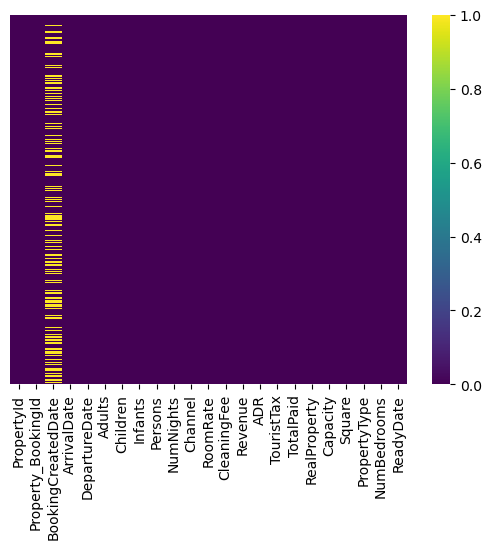

In [6]:
# Verificar los nulos
sns.heatmap(merged_df.isnull(),cmap = 'viridis')
plt.yticks([])
plt.show()

In [7]:
# Actualizar 'Persons' donde 'Children' e 'Infants' son cero
merged_df.loc[(merged_df['Children'] == 0) & (merged_df['Infants'] == 0), 'Persons'] = merged_df['Adults']
print(merged_df[['Adults', 'Children', 'Infants', 'Persons']].head())

# Contar la cantidad total de reservas
total_reservas = merged_df.shape[0]  # La cantidad de filas en el DataFrame es el total de reservas
print(f"\nCantidad total de reservas: {total_reservas}")

   Adults  Children  Infants  Persons
0       2         0        0        2
1       3         0        0        3
2       3         0        0        3
3       5         0        0        5
4       5         0        0        5

Cantidad total de reservas: 87037


In [8]:
# Contar la cantidad total de reservas
total_reservas = merged_df.shape[0]  # Total de reservas
print(f"\nCantidad total de reservas: {total_reservas}")

# Contar reservas con solo adultos
reservas_solo_adults = merged_df[(merged_df['Children'] == 0) & (merged_df['Infants'] == 0)].shape[0]
print(f"Cantidad de reservas con solo adultos: {reservas_solo_adults}")

# Contar reservas con solo adultos y niños (Infants == 0)
reservas_adults_children = merged_df[(merged_df['Children'] > 0) & (merged_df['Infants'] == 0)].shape[0]
print(f"Cantidad de reservas con solo adultos y niños: {reservas_adults_children}")

# Contar reservas con solo adultos e infantes (Children == 0)
reservas_adults_infants = merged_df[(merged_df['Adults'] > 0) & (merged_df['Children'] == 0) & (merged_df['Infants'] > 0)].shape[0]
print(f"Cantidad de reservas con solo adultos e infantes: {reservas_adults_infants}")

# Contar reservas con solo niños e infantes (Adults == 0)
reservas_children_infants = merged_df[(merged_df['Children'] > 0) & (merged_df['Infants'] > 0) & (merged_df['Adults'] == 0)].shape[0]
print(f"Cantidad de reservas con solo niños e infantes: {reservas_children_infants}")

# Contar reservas con adultos, niños e infantes
reservas_adults_children_infants = merged_df[(merged_df['Adults'] > 0) & (merged_df['Children'] > 0) & (merged_df['Infants'] > 0)].shape[0]
print(f"Cantidad de reservas con adultos, niños e infantes: {reservas_adults_children_infants}")



Cantidad total de reservas: 87037
Cantidad de reservas con solo adultos: 66321
Cantidad de reservas con solo adultos y niños: 18386
Cantidad de reservas con solo adultos e infantes: 1244
Cantidad de reservas con solo niños e infantes: 0
Cantidad de reservas con adultos, niños e infantes: 1086


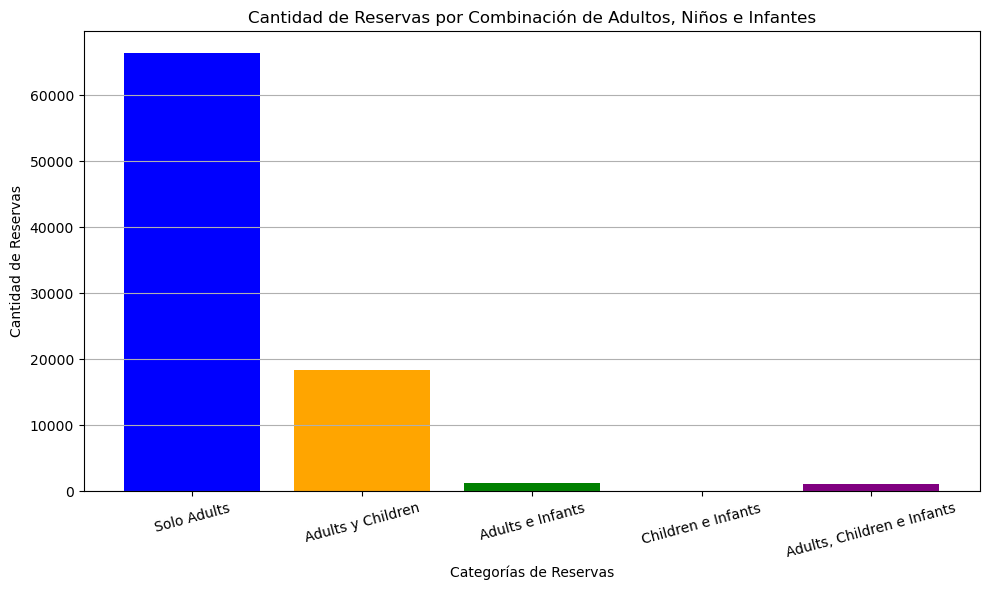

In [9]:
# Datos para graficar
categories = [
    'Solo Adults',
    'Adults y Children',
    'Adults e Infants',
    'Children e Infants',
    'Adults, Children e Infants'
]
counts = [
    reservas_solo_adults,
    reservas_adults_children,
    reservas_adults_infants,
    reservas_children_infants,
    reservas_adults_children_infants
]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Cantidad de Reservas por Combinación de Adultos, Niños e Infantes')
plt.xlabel('Categorías de Reservas')
plt.ylabel('Cantidad de Reservas')
plt.xticks(rotation=15)
plt.grid(axis='y')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [10]:
# Contar la frecuencia de cada tipo de propiedad
property_counts = merged_df['PropertyType'].value_counts()

# Convertir el conteo a un DataFrame
property_counts_df = property_counts.reset_index()
property_counts_df.columns = ['PropertyType', 'Count']

# Mostrar los tipos de propiedad más comunes
print(property_counts_df)

  PropertyType  Count
0    Apartment  57892
1          Apa  21303
2      Unknown   7748
3        House     94


In [11]:
## Con esto Podemos ver que las diversas fuentes de ingreso de datos traian un grupo con el nombre de Apa
## Refiriendose a Apartment asi que reemplazaremos este para un mejor analisis y visualizacion

In [12]:
# Reemplazar "Apa" por "Apartment" en PropertyType
merged_df.loc[merged_df['PropertyType'].str.contains('Apa', case=False, na=False), 'PropertyType'] = 'Apartment'


In [13]:
# Contar la frecuencia de cada tipo de propiedad
property_counts = merged_df['PropertyType'].value_counts()

# Convertir el conteo a un DataFrame
property_counts_df = property_counts.reset_index()
property_counts_df.columns = ['PropertyType', 'Count']

# Mostrar los tipos de propiedad más comunes
print(property_counts_df)

  PropertyType  Count
0    Apartment  79195
1      Unknown   7748
2        House     94


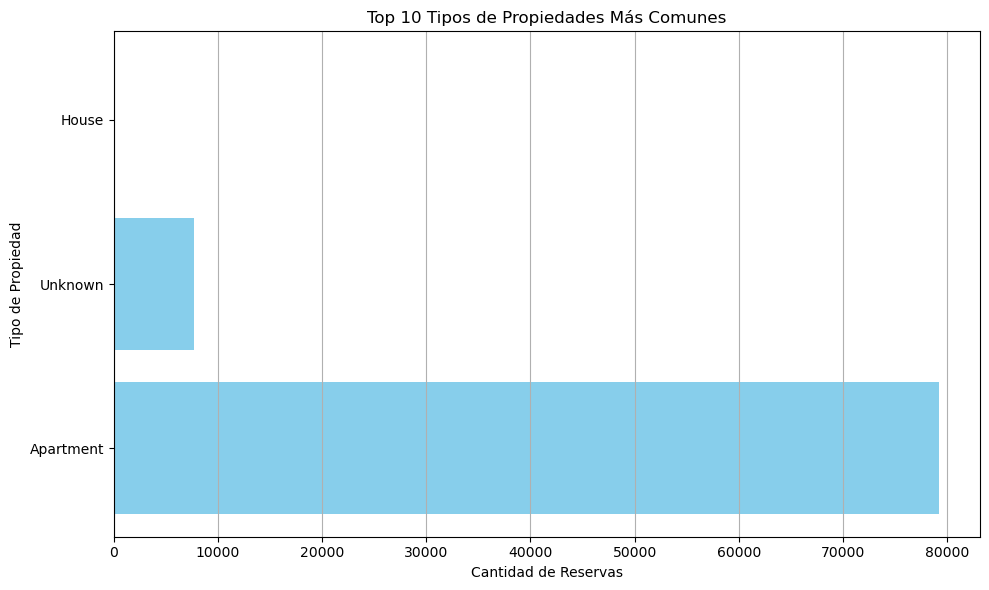

In [14]:
# Graficar los tipos de propiedad más comunes
plt.figure(figsize=(10, 6))
plt.barh(property_counts_df['PropertyType'].head(10), property_counts_df['Count'].head(10), color='skyblue')
plt.title('Top 10 Tipos de Propiedades Más Comunes')
plt.xlabel('Cantidad de Reservas')
plt.ylabel('Tipo de Propiedad')
plt.grid(axis='x')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [15]:
# Obtener los 10 PropertyId con los mayores TotalPaid
top_n_paid = merged_df.nlargest(10, 'TotalPaid')[['PropertyId', 'TotalPaid']]

# Mostrar los resultados
print("PropertyId con los mayores TotalPaid:")
print(top_n_paid)

PropertyId con los mayores TotalPaid:
       PropertyId  TotalPaid
46261       43065   36150.00
64998       43065   30389.00
51089       42852   30100.20
65893       43065   22572.26
15638       43425   20283.09
12094        5931   20178.00
13126        4786   19771.15
12714        6285   19163.00
75115       42607   18934.72
66342       43046   18820.00


In [16]:
# Filtrar registros donde Persons es mayor que 0 para evitar división por cero
merged_df = merged_df[merged_df['Persons'] > 0]

# Calcular el promedio de TotalPaid por persona y agregarlo como una nueva columna
merged_df['AvgPaidPerPerson'] = merged_df['TotalPaid'] / merged_df['Persons']

# Obtener los 10 PropertyId con los mayores promedios de TotalPaid por persona
top_n_avg_paid = merged_df.nlargest(10, 'AvgPaidPerPerson')[['PropertyId', 'AvgPaidPerPerson']]

# Mostrar los resultados
print("PropertyId con los mayores promedios de TotalPaid por persona:")
print(top_n_avg_paid)

PropertyId con los mayores promedios de TotalPaid por persona:
       PropertyId  AvgPaidPerPerson
12094        5931          20178.00
12714        6285          19163.00
64998       43065          15194.50
65868        3964          12790.00
35371       43141          11361.80
43487       43016          10770.63
43488       43016          10770.63
39061       43349          10322.95
69549       42673          10243.00
65856       43119          10228.33


In [17]:
# Filtrar registros donde Persons y NumNights son mayores que 0 para evitar división por cero
merged_df = merged_df[(merged_df['Persons'] > 0) & (merged_df['NumNights'] > 0)]

# Calcular el promedio de TotalPaid por persona y por noche
merged_df['AvgPaidPerPersonPerNight'] = merged_df['TotalPaid'] / merged_df['Persons'] / merged_df['NumNights']

# Obtener los 10 PropertyId con los mayores promedios de TotalPaid por persona y por noche
top_n_avg_paid = merged_df.nlargest(10, 'AvgPaidPerPersonPerNight')[['PropertyId', 'AvgPaidPerPersonPerNight']]

# Mostrar los resultados
print("PropertyId con los mayores promedios de TotalPaid por persona y por noche:")
print(top_n_avg_paid)

PropertyId con los mayores promedios de TotalPaid por persona y por noche:
       PropertyId  AvgPaidPerPersonPerNight
36393       43034               1224.677500
35950       43034               1194.136667
74312        3963               1002.480000
80112        5931                997.480000
53462       42962                949.500000
73521       42607                801.595556
56819       43214                760.600000
53174       43214                749.200000
22697       43009                749.192500
14081       43034                697.826667


In [18]:
# Filtrar registros donde Persons y NumNights son mayores que 0 para evitar división por cero
merged_df = merged_df[(merged_df['Persons'] > 0) & (merged_df['NumNights'] > 0)]

# Calcular el promedio de TotalPaid por persona y por noche
merged_df['AvgPaidPerPersonPerNight'] = merged_df['TotalPaid'] / merged_df['Persons'] / merged_df['NumNights']

# Obtener los 10 PropertyId con los menores promedios de TotalPaid por persona y por noche
bottom_n_avg_paid = merged_df.nsmallest(10, 'AvgPaidPerPersonPerNight')[['PropertyId', 'AvgPaidPerPersonPerNight']]

# Mostrar los resultados
print("PropertyId con los menores promedios de TotalPaid por persona y por noche:")
print(bottom_n_avg_paid)

PropertyId con los menores promedios de TotalPaid por persona y por noche:
       PropertyId  AvgPaidPerPersonPerNight
66352        4952                   -75.000
44104       42926                    -6.125
6005        43407                    -5.390
17047       43540                     0.000
43653       43337                     0.000
61185       43144                     0.000
61343       43147                     0.000
61344       43140                     0.000
64750       43144                     0.000
64751       43147                     0.000


In [19]:
# Filtrar registros donde Persons, NumNights y TotalPaid son mayores que 0
merged_df = merged_df[(merged_df['Persons'] > 0) & (merged_df['NumNights'] > 0) & (merged_df['TotalPaid'] > 0)]

# Calcular el promedio de TotalPaid por persona y por noche
merged_df['AvgPaidPerPersonPerNight'] = merged_df['TotalPaid'] / merged_df['Persons'] / merged_df['NumNights']

# Obtener los 10 PropertyId con los menores promedios de TotalPaid por persona y por noche
bottom_n_avg_paid = merged_df.nsmallest(10, 'AvgPaidPerPersonPerNight')[['PropertyId', 'AvgPaidPerPersonPerNight']]

# Mostrar los resultados
print("PropertyId con los menores promedios de TotalPaid por persona y por noche (sin ceros ni negativos):")
print(bottom_n_avg_paid)

PropertyId con los menores promedios de TotalPaid por persona y por noche (sin ceros ni negativos):
       PropertyId  AvgPaidPerPersonPerNight
65350       43171                  0.000011
53617        9971                  0.000027
65478       43035                  0.000040
65477       43033                  0.000041
40274       43211                  0.000110
71585        4181                  0.000111
58043       43211                  0.000156
41228       42994                  0.000208
73904        6285                  0.000244
41754       43308                  0.000250


In [20]:
# Filtrar registros donde Persons, NumNights son enteros positivos y TotalPaid es un entero positivo
merged_df = merged_df[
    (merged_df['Persons'] > 0) & 
    (merged_df['NumNights'] > 0) & 
    (merged_df['TotalPaid'] > 0) & 
    (merged_df['Persons'].apply(lambda x: x.is_integer())) & 
    (merged_df['NumNights'].apply(lambda x: x.is_integer())) & 
    (merged_df['TotalPaid'].apply(lambda x: x.is_integer()))
]

# Calcular el promedio de TotalPaid por persona y por noche
merged_df['AvgPaidPerPersonPerNight'] = merged_df['TotalPaid'] / merged_df['Persons'] / merged_df['NumNights']

# Obtener los 10 PropertyId con los menores promedios de TotalPaid por persona y por noche
bottom_n_avg_paid = merged_df.nsmallest(10, 'AvgPaidPerPersonPerNight')[['PropertyId', 'AvgPaidPerPersonPerNight']]

# Mostrar los resultados
print("PropertyId con los menores promedios de TotalPaid por persona y por noche (sin ceros, negativos y solo enteros):")
print(bottom_n_avg_paid)

PropertyId con los menores promedios de TotalPaid por persona y por noche (sin ceros, negativos y solo enteros):
       PropertyId  AvgPaidPerPersonPerNight
78021        4869                  0.031250
78274        4259                  0.111111
77344        9971                  0.142857
43858       42926                  0.200000
82880        5931                  0.250000
38776       43019                  0.333333
78756        4869                  0.333333
66271       42807                  0.766284
53281       42694                  1.000000
66400       42888                  1.111111


In [21]:
# Filtrar registros donde Persons, NumNights son enteros positivos y TotalPaid es un entero positivo
merged_df = merged_df[
    (merged_df['Persons'] > 0) & 
    (merged_df['NumNights'] > 0) & 
    (merged_df['TotalPaid'] > 0) & 
    (merged_df['Persons'].apply(lambda x: x.is_integer())) & 
    (merged_df['NumNights'].apply(lambda x: x.is_integer())) & 
    (merged_df['TotalPaid'].apply(lambda x: x.is_integer()))
]

# Calcular el promedio de TotalPaid por persona y por noche
merged_df['AvgPaidPerPersonPerNight'] = merged_df['TotalPaid'] / merged_df['Persons'] / merged_df['NumNights']

# Filtrar resultados para mantener solo aquellos con un promedio entero mayor a 0
filtered_avg_paid = merged_df[merged_df['AvgPaidPerPersonPerNight'] > 0]
filtered_avg_paid['AvgPaidPerPersonPerNight'] = filtered_avg_paid['AvgPaidPerPersonPerNight'].astype(int)  # Convertir a entero

# Obtener los 10 PropertyId con los menores promedios de TotalPaid por persona y por noche
bottom_n_avg_paid = filtered_avg_paid.nsmallest(10, 'AvgPaidPerPersonPerNight')[['PropertyId', 'AvgPaidPerPersonPerNight']]

# Mostrar los resultados
print("PropertyId con los menores promedios de TotalPaid por persona y por noche (enteros mayores a 0):")
print(bottom_n_avg_paid)

PropertyId con los menores promedios de TotalPaid por persona y por noche (enteros mayores a 0):
       PropertyId  AvgPaidPerPersonPerNight
38776       43019                         0
43858       42926                         0
66271       42807                         0
77344        9971                         0
78021        4869                         0
78274        4259                         0
78756        4869                         0
82880        5931                         0
53281       42694                         1
65934        5932                         1


In [22]:
# Contar la cantidad de veces que se repite cada nombre en la columna Channel
channel_counts = merged_df['Channel'].value_counts().reset_index()

# Renombrar las columnas para una mejor legibilidad
channel_counts.columns = ['Channel', 'Count']

# Mostrar los resultados
print("Cantidad de veces que se repite cada nombre en la columna Channel:")
print(channel_counts)

Cantidad de veces que se repite cada nombre en la columna Channel:
                        Channel  Count
0                        Airbnb   3083
1                   Booking.com   1257
2                        Manual    242
3      Stay U-nique.com Website    118
4       Marriott Homes & Villas     64
5                      HomeLike     46
6                     Idealista     38
7              Expedia Collects     22
8                          Vrbo     21
9                       Unknown     18
10                   RentTheSun     12
11                     HomeToGo      8
12              Repeat Customer      6
13                    UniPlaces      5
14                         Badi      4
15                   Plum Guide      3
16                       Google      2
17                       Holidu      2
18              HousingAnywhere      2
19                    SpotAHome      2
20          Expedia Hotel Coll.      2
21                    HomySpace      1
22       TheCollectionBarcelona     

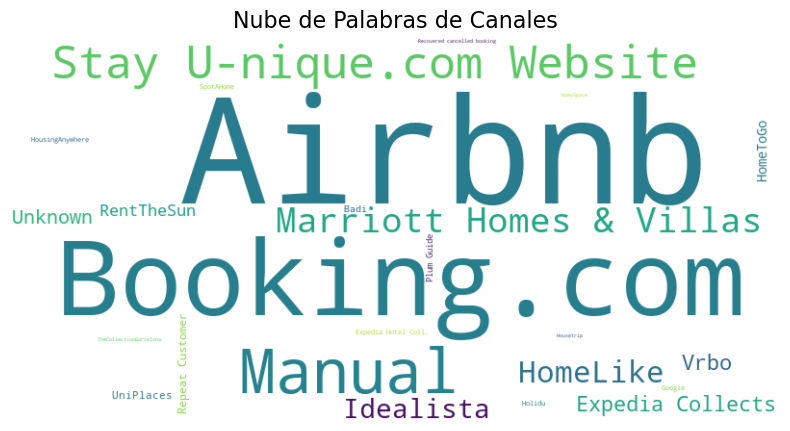

In [23]:
# Contar la cantidad de veces que se repite cada nombre en la columna Channel
channel_counts = merged_df['Channel'].value_counts()

# Crear un diccionario para la nube de palabras
channel_dict = channel_counts.to_dict()

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(channel_dict)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.title('Nube de Palabras de Canales', fontsize=16)
plt.show()

In [ ]:
##La data se puede perfilar para un analisis a mayor profundidad,tambien se puede debe realizar aun una mayor limpieza de datos
##Debido a que Durante este pequeño analisis pude hallar ciertas incongruencias y error en el dataset despues de su primera limpieza
##Estos nos ayudara a perfilar el Dataset para una mejor comprension y facilidad de uso a la hora de buscar algun objetivo en particular